# Estimating the NAs in the dataset

Our coral dataset has 620 rows and 39 columns. We found 113 missing values in one of our predictor variables, and due to the small dataset size, we work to predict those values here. 

We use two methods to estimate - lasso regression and k-means clustering - and compare both to using the mean. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx

### Read in the data

In [2]:
# read in the data
df = pd.read_csv("../Data/Hawaii_RegimesPredictors.txt", sep="\t", decimal=",")

In [3]:
print(df.shape)
df.head()

(620, 39)


,id_spatial,Long,Lat,Island,Coral,CCA,Turf,Macro,Other,Grazers,...,PAR_STD,WAV_CLIM_M,WAV_ANOM_F,Complexity,Depth,Regime,Regime1,Regime2,Regime3,Regime5
0,4,-157.307727,21.106717,Molokai,1.023891,1.706485,77.815700,18.088737,1.023891,1.324986,...,8.5628,36.542160,0.083878,4.889608,2.8000,1,1,0,0,0
1,5,-157.304986,21.113497,Molokai,3.555556,1.333333,83.555556,9.777778,0.888889,0.890407,...,8.5628,36.542160,0.083878,3.793523,7.3152,1,1,0,0,0
2,6,-157.303306,21.124814,Molokai,17.620555,6.348836,44.875760,25.716525,4.836712,4.628477,...,9.4296,38.007866,0.084089,5.275938,11.5000,2,0,1,0,0
3,8,-157.299938,21.148297,Molokai,0.675676,1.351351,86.486487,0.337838,5.743243,0.069128,...,9.4296,39.139775,0.087039,2.511288,29.1000,1,1,0,0,0
4,9,-157.300286,21.128897,Molokai,4.000000,3.111111,53.333333,17.333333,21.777778,11.775000,...,9.4296,40.587803,0.084932,6.865359,10.0584,2,0,1,0,0


## Data prep

In [4]:
def data_prep(df):
    df = df.astype({"id_spatial": "category", "Island": "category", "Habitat_Modification": "category", 
               "Invasive_Algae": "category", "Regime": "category", "Regime1": "category", 
               "Regime2": "category", "Regime3": "category", "Regime5": "category"})
    return df
random.seed(47)
df = data_prep(df)

# Explore the data set

In [5]:
# fig = plt.figure(figsize=(15,50))
# for i in range(df.shape[1]):
#     if type(df.loc[0,df.columns[i]]) == type(df.loc[0,df.columns[1]]):
#         ax = fig.add_subplot(18,3,i+1)
#         ax.hist(df.loc[:,df.columns[i]])
#         plt.title("{}".format(df.columns[i]))
#         plt.tight_layout()

#### Which columns have NA's?

In [6]:
na_cols = df.apply(lambda x : x.isna().sum())
na_cols[na_cols>0]

Complexity    113
Depth          12
dtype: int64

### Depth

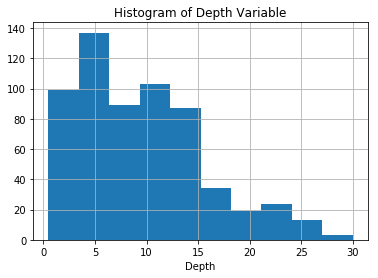

In [7]:
plt.hist(df.Depth[df.Depth.notna()])
plt.title("Histogram of Depth Variable")
plt.xlabel("Depth")
plt.grid()

We'll just replace the 12 missing values of Depth with the median value of Depth

In [8]:
df.loc[df.Depth.isna(), 'Depth'] = df.Depth[df.Depth.notna()].median()

# Check if the NAs are gone:
na_cols = df.apply(lambda x : x.isna().sum())
na_cols[na_cols>0]

Complexity    113
dtype: int64

## Estimate the missing complexity values

#### Plot distribution of complexity variable

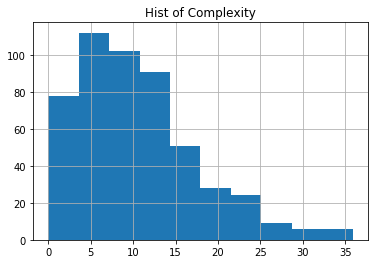

In [9]:
plt.hist(df.Complexity[df.Complexity.notna()])
plt.title("Hist of Complexity")
plt.grid()
plt.show()

#### Data prep

In [10]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale

# Create dataset of only rows that are not NA. 
# df_complex = df[df.Complexity.notna()]
df_complex = df.copy()
print("df_complex.shape", df_complex.shape)

# correlations
#print (df[cols].corrwith(pd.Series(v, index=df.columns), axis=1))

response = df_complex['Complexity']
predictors = df_complex.columns[:-7]
predictors = predictors[1:]
df_complex = df_complex[predictors]
df_complex = df_complex.drop('Effluent', axis=1)
# print(df_complex.columns)

# change Island variable to numeric encoding. 
lb = LabelEncoder()
island_dummy = lb.fit_transform(df_complex.Island)
island_dummy
lb.inverse_transform(island_dummy)
df_complex.Island = island_dummy 

# Scale data 
cols = df_complex.columns
df_complex_means = np.mean(df_complex, axis=0)
df_complex_stds  = np.std(df_complex, axis=0)
df_complex_scaled = scale(df_complex.values)

df_complex_scaled = pd.DataFrame(data=df_complex_scaled, columns=cols)

df_complex_scaled

df_complex_scaled = df_complex_scaled[response.notna()]
response_notna = response[response.notna()]

# Split into train, validation
complex_train, complex_test, complex_train_y, complex_test_y = train_test_split(df_complex_scaled, response_notna, test_size=0.15)

complex_train, complex_valid, complex_train_y, complex_valid_y = train_test_split(complex_train, complex_train_y, test_size=0.2)

assert(complex_train.shape[0] + complex_valid.shape[0] + complex_test.shape[0] == df_complex_scaled.shape[0])

df_complex.shape (620, 39)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [11]:
na_cols = complex_valid.apply(lambda x : x.isna().sum())
na_cols[na_cols>0]

Series([], dtype: int64)

##### RMSE & lasso helper

In [12]:
def calc_rmse(predictions, true_values, n):
    return np.sqrt(1/n*sum((predictions - true_values)**2))

def run_lasso(train, train_response, valid, valid_response, lamb):
    lassoreg = Lasso(alpha = lamb, normalize=True, max_iter=1e5)
    lassoreg.fit(train, train_response)
    y_pred = lassoreg.predict(valid)
    rss = calc_rmse(y_pred, valid_response, valid.shape[0])
    return rss, y_pred, lassoreg

##### Run Lasso simulations

In [13]:
lambdas = [10, 1, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
RMSE = np.zeros(len(lambdas))
best_rmse_lasso = 100000 
best_lambda = 0
best_predictions = None
best_model = None
i = 0
for lamb in lambdas:
    current_rmse, y_pred, lasso_model = run_lasso(complex_train, complex_train_y, complex_valid, complex_valid_y, lamb)
    RMSE[i] = current_rmse
    if current_rmse < best_rmse_lasso:
        best_rmse_lasso = current_rmse
        best_lambda = lamb
        best_predictions = y_pred
        best_model = lasso_model
    i += 1

print(best_lambda)
print(best_rmse_lasso)
print(best_predictions)

1e-06
6.07668701035269
[ 5.25093511  7.03804356  7.11488131 11.29432214 11.79018384  7.78605454
  7.72099162 13.40453004 13.19721598 16.97081465  4.35797592 15.17523014
  2.28408453 10.09376263  9.05937141 15.73521326 10.15707921 14.45408429
 11.74899372 11.25154677  9.44400035  7.71826001  9.42965825 16.63541458
  9.33091258  7.07579717 12.65125607 12.86565038 15.89112582 11.71462843
  9.01589117 12.99958787  9.94377451 10.12286136  8.0421094   6.56943624
  6.9083517   4.24355915  8.73054004 12.02105792 12.0195557   7.74259164
 15.68995327 10.86006023 24.27389128  8.44430192  8.9397783  13.15631299
 10.01512138  1.74801884  5.81406274 11.25775147 13.96223154  5.2269796
  7.62669253  7.60840654 11.94207792 17.18174926 11.90717358 11.32702509
  9.21140445  5.42955532 21.12122264  6.22176538  9.30135708  7.12851583
 18.92694475 10.67286097  0.54657061 13.31220486  6.46599605 19.92290027
 10.65956859 13.95876508  5.5174617  16.2914344   7.7820103   3.56772335
 15.88757225 16.0864501  18.3

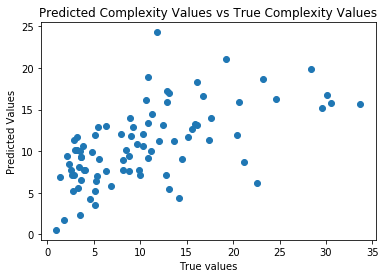

In [14]:
plt.scatter(complex_valid_y, y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted Values")
plt.title("Predicted Complexity Values vs True Complexity Values")
plt.show()

Text(0.5, 1.0, 'RMSE of Lasso Regression by Lambda Values')

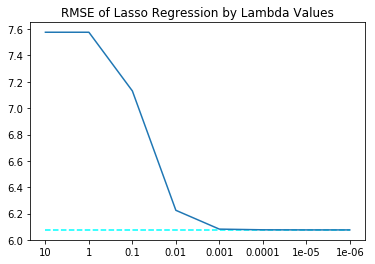

In [15]:
plt.plot(RMSE)
plt.hlines(min(RMSE), xmin=0, xmax=7, colors='aqua', linestyles='dashed')
plt.xticks(range(len(lambdas)), lambdas)
plt.title("RMSE of Lasso Regression by Lambda Values")

### How does it compare to estimating the mean? Slightly better... roughly 1 on average

In [29]:
mean_y_pred = complex_train_y.mean()
using_mean = calc_rmse(mean_y_pred, complex_test_y, complex_test.shape[0])
print("RMSE using lasso with lambda {}: ".format(best_lambda), best_rmse_lasso)
print("RMSE using mean:                   ", using_mean)

RMSE using lasso with lambda 1e-06:  6.07668701035269
RMSE using mean:                    7.039585884216736


## K-means using Long and Lat

In [31]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

In [32]:
# complex_train, complex_test, complex_train_y, complex_test_y
# complex_valid, complex_valid_y

# Takes as input: normalized train and validation data. 
# unnormalized y validation values

def compute_k_means(train, valid, valid_y, n_clusters, n_init):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init)

    kmeans.fit(train)
    # kmeans.cluster_centers_

    cluster_predictions = kmeans.predict(valid)
    cluster_complexity_means = valid_y.groupby(cluster_predictions).mean()
    cluster_complexity_means

    predictions = np.zeros(len(valid))
    for i in range(len(valid)):
        if cluster_predictions[i] >= len(cluster_complexity_means):
            predictions[i] = cluster_predictions.mean()
        else:
            predictions[i] = cluster_complexity_means[cluster_predictions[i]]
            
    return predictions

# E.g.,
#   compute_k_means(complex_train, complex_valid, complex_valid_y, 10, 10)

### Run simulation to find best num_clusters

In [33]:
num_clusters = np.arange(30) + 2
RMSE = np.zeros(len(num_clusters))
count=0
best_RMSE = 10000
best_num_cluster = 0
best_predictions = None
for nc in num_clusters:
    predictions = compute_k_means(complex_train, complex_valid, complex_valid_y, nc, 10)
    RMSE[count] = calc_rmse(predictions, complex_valid_y, len(complex_valid))
    if RMSE[count] < best_RMSE:
        best_RMSE = RMSE[count]
        best_num_clusters = nc
        best_predictions = predictions
    count += 1
print("RMSE: ", RMSE)
print("best RMSE: ", best_RMSE)
print("best num clusters: ", best_num_clusters)

RMSE:  [7.4358588  7.12752549 6.89078267 6.42871299 6.78877541 6.78059169
 6.28440364 6.60791264 6.16630591 6.38247438 6.14296373 5.88337147
 6.8505979  6.02227561 5.6457947  5.18596059 5.87789485 6.37830361
 6.24081412 5.82250621 5.65789203 5.85296846 6.66531297 6.02731921
 5.88116204 5.60647312 6.16196186 6.65902535 5.87882698 5.74112891]
best RMSE:  5.18596059286605
best num clusters:  17


Text(0.5, 1.0, 'RMSE of k-means by Num Clusters')

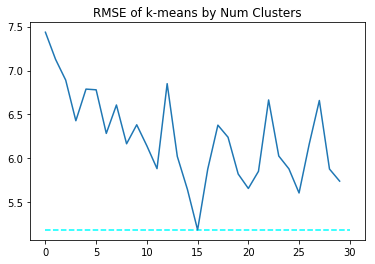

In [34]:
plt.plot(RMSE)
plt.hlines(min(RMSE), xmin=0, xmax=30, colors='aqua', linestyles='dashed')
plt.title("RMSE of k-means by Num Clusters")

### How does k-means compare to the mean?

##### Pretty high variance in the RMSE

In [35]:
mean_y_pred = complex_train_y.mean()
using_mean = calc_rmse(mean_y_pred, complex_test_y, complex_test.shape[0])
print("RMSE using k-means with {} clusters: ".format(best_num_clusters), best_RMSE)
print("RMSE using mean:                     ", using_mean)

RMSE using k-means with 17 clusters:  5.18596059286605
RMSE using mean:                      7.039585884216736


## Replace missing NA values with k-mean estimations

In [17]:
complexity_NA = df[df.Complexity.isna()]
predictors = complexity_NA.columns[:-7]
predictors = predictors[1:]
complexity_NA = complexity_NA[predictors]
complexity_NA.columns

# change Island variable to numeric encoding. 
lb = LabelEncoder()
island_dummy = lb.fit_transform(complexity_NA.Island)
complexity_NA.Island = island_dummy 
complexity_NA = complexity_NA.drop('Effluent', axis=1)

In [19]:
np.mean(df_complex) - np.mean(complexity_NA)

Long                           -0.041684
Lat                             0.015982
Island                          0.968299
Coral                           1.220487
CCA                             0.175865
Turf                           -1.348089
Macro                          -0.852534
Other                           0.548724
Grazers                       -11.368311
Scrapers                       -6.298180
Browsers                       -9.847985
Predators                      -8.652178
Secondary                      -4.655676
Sedimentation                  -2.357614
New_Development                 0.006219
Habitat_Modification            0.057322
Invasive_Algae                  0.035912
Fishing_Comm_Total              0.167775
Fishing_NonComm_Boat_Total      0.264726
Fishing_NonComm_Shore_Line      3.801915
Fishing_NonComm_Shore_Net       0.515235
Fishing_NonComm_Shore_Spear     1.326633
SST_CLIM_M                      0.102300
SST_STD                        -0.006184
CHL_CLIM_M      

In [20]:
# Convert to nd array
if type(df_complex_means) == type(pd.Series([1,2])):
    df_complex_means = np.array(df_complex_means.values, dtype=np.float64)
if type(df_complex_stds) == type(pd.Series([1,2])):
    df_complex_stds = np.array(df_complex_stds.values, dtype=np.float64)

In [21]:
# Normalize with scale function
normalized_preds_scale = scale(complexity_NA.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### use the lasso regression to estimate the missing values

In [23]:
missing_complexity_predictions = lasso_model.predict(normalized_preds_scale)
missing_complexity_predictions

array([ 6.381398  ,  9.72533718,  9.60264555,  3.48157412, 10.91622605,
        9.71809397,  8.70897349, 13.22849318, 23.17222507, 20.28876687,
        9.46333003, 16.60956999,  6.36719361,  9.24365409,  9.0860404 ,
       12.83364044, 10.43444394, 10.33741348, 13.32037335, 17.53357164,
        6.83873584,  8.31904156, 12.0669673 ,  8.10570595,  3.22517438,
        6.2648425 , 11.05594194,  6.26135102, 13.90120807,  3.90884614,
        5.73402955, 12.63936493,  5.42991554,  9.80129975, 12.77229132,
       12.41083472, 11.80491723,  6.62146198, 12.10527605, 12.0758077 ,
       12.65723062, 13.7731165 , 11.38010792, 13.00054535, 11.32157454,
       11.54255117, 13.47464637, 11.36519785,  7.19947784,  6.66635051,
       19.1318603 , 19.54430312, 13.74577197, 12.42174814,  8.40322168,
       11.24616843, 15.69129326,  8.08046999, 17.62730771, 13.55609295,
       15.8023509 , 15.03265017, 17.56760071, 13.65014579, 12.76339284,
        5.84117651,  7.83773414,  5.89279789, 14.69486583, 11.44

In [24]:
df.loc[df.Complexity.isna(), 'Complexity'] = missing_complexity_predictions

### Check

In [25]:
# Check if they are filled in? 
na_cols = df.apply(lambda x : x.isna().sum())
na_cols[na_cols>0].count()

0

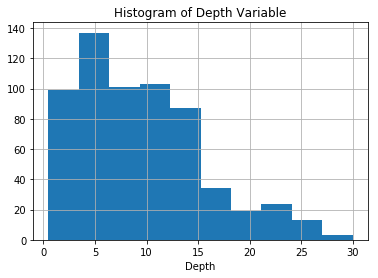

In [26]:
plt.hist(df.Depth[df.Depth.notna()])
plt.title("Histogram of Depth Variable")
plt.xlabel("Depth")
plt.grid()

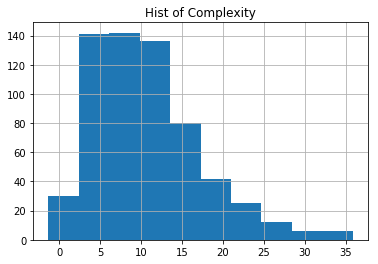

In [27]:
plt.hist(df.Complexity[df.Complexity.notna()])
plt.title("Hist of Complexity")
plt.grid()
plt.show()

In [41]:
df.to_csv("../Data/Hawaii_RegimesPredictors_complete.txt", sep='\t', decimal=',', index=False)

In [42]:
df2 = pd.read_csv("../Data/Hawaii_RegimesPredictors_complete.txt", sep="\t", decimal=",")